# Identify the candidate blooming bacteria

The goal of this notebook is to identify candidate bacteria (as observed by 16S rRNA V4 reads) which appear to bloom under shipping conditions. We identify candidates in two parts: first, we'll look for bacteria which grew at room temperature in storage studies; second, we'll look at shipped American Gut fecal samples and compared them to fresh-frozen fecal samples. We use the combined technique because the storage studies were limited in sample size and individuals, while the comparison with fresh-frozen studies offers many more individuals and samples. 

Briefly, this process will involve the following steps:

1. Load the datasets:

    1. Preservation study (Song [1](#1); Qiita ID [10389](https://qiita.ucsd.edu/study/description/10394))
    2. Mayo Clinic Fecal Stability (Mayo [2](#2); Qiita ID [10184](https://qiita.ucsd.edu/study/description/10184))
    3. The American Gut Project (AGP; Qiita ID [10317](https://qiita.ucsd.edu/study/description/10317))
    4. The Personal Genome Project (PGP; Qiita ID [1189](https://qiita.ucsd.edu/study/description/1189))
    5. Human Genetics and the Gut Microbiome (Twins [3](#3); Qiita ID [2014](https://qiita.ucsd.edu/study/description/2014))
    6. A Whole Grain diet study (ERC [4](#4); Qiita ID [1481](https://qiita.ucsd.edu/study/description/1481))
    
2. Calculate the fold change per sOTU in the storage studies (Mayo and Song) over time
3. Calculate the fold change in the AGP compared to fresh-frozen studies (PGP, Twins, and ERC)
4. Identify candidate blooming bacteria by combining the fold changes in steps 2 and 3
5. Plot the scatter of the fold change per sOTU with highlighting the candidate blooming bacteria
6. Plot taxonomy plots before and after filtering for blooms on the American Gut and fresh frozen studies.

Let's start by loading the necessary Python functions. 

In [78]:
import hashlib

import matplotlib as mpl
# load modules used in the analysis
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import skbio
from skbio.stats.composition import closure


from bloom.stats import permutation_mean

# plots inside the notebook
# %matplotlib notebook
%matplotlib inline

from statsmodels.sandbox.stats.multicomp import multipletests
# set the random seed
np.random.seed(2016)

# set visualization column size for pandas
pd.set_option('max_colwidth', 20)
sn.set_style('white')

In [79]:
import pandas as pd
import numpy as np

def exploding_panda(_bt):
    """BIOM to pandas DataFrame 

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.

    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    """
    m = _bt.matrix_data
    data = m.toarray()
    return pd.DataFrame(data, index=_bt.ids('observation'),
                        columns=_bt.ids('sample'))

    return out

# Loading all experimental data

We'll write a quick function to load the data. We'll load the BIOM table (`biom_fp`). We'll load the specified metadata columns (`meta_fp` and `keep_columns`). Then, we'll filter the data to include only samples with at least 1000 counts/sample (`depth`) and that fit the filtering criteria (`filters`). Finally, we'll add information about the study and preservation method to make later analysis easier.

In [3]:
def load_studies(biom_fp, meta_fp, name, preservation, keep_columns=None, 
                 filters=None, depth=1000):
    """Loads the studies more easily
    
    Parameters
    ----------
    biom_fp : str
        The filepath to the BIOM table
    meta_fp : str
        The filepath to the mapping file
    name : str
        The name of the study
    preservation : {"NONE", "STORAGE", "FRESH_FROZEN"}
        Denotes what preservation method, if any, was used.
    keep_columns : list of str
        The columns within the mapping file to retain.
    filters : dict
        Any filters to apply to the metadata
    depth : int
        A sequencing depth to rarefy to.
    """
    if filters is None:
        filters = {}
        
    # Loads the mapping file
    if keep_columns == None:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str)
    else:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str, usecols=keep_columns)
    meta.set_index('#SampleID', inplace=True)
    
    # Loads the biom table
    sotu = biom.load_table(biom_fp)

    # We'll first filter the table by sequencing depth
    sotu = sotu.filter(lambda val, id_, md: val.sum() > depth, axis='sample')
    meta = meta.loc[sotu.ids(axis='sample')]
    
    # Filters the samples
    def filter_meta(x):
        return np.all([x[k] == v for k, v in filters.items()])
    
    meta_f = meta.loc[meta.apply(filter_meta, axis=1)].copy()
    meta_f['STUDY'] = name
    meta_f['PRESERVATION'] = preservation
    sotu_f = sotu.filter(meta_f.index)
    
    return meta_f, sotu_f

## Song fecal stability study

The Song fecal stability study [[1](#1)] compares the stability of human and dog fecal samples under a variety of storage conditions. For the purposes of candidate bloom identification *for human specimens*, we will only use samples which originated from humans.

We will only use samples with no preservative stored at ambient temperature for 7, 14 and 28 days (compared to samples sequenced at day 0).

In [4]:
song_meta, song_sotu = load_studies(
    biom_fp = '../data/storage.sejin.clean.withtax.biom',
    meta_fp = '../data/map.storage.sejin.txt',
    name='SONG',
    preservation='STORAGE',
    keep_columns=['#SampleID', 'preservative', 'temperature', 'temp2', 'species', 
                  'time_numeric', 'subject'],
    filters={'preservative': 'None',
             'temperature': 'amb',
             'species': 'human'},
    )

The sample is filtered to only include perservative-free samples from humans stored at room temperature. These include samples collected at day 0 and immediately sequenced, which we use as a reference. We will only use samples with at least 1000 sequences.

## Mayo fecal stability study

The Mayo fecal stability study [[2](#2)] compares the effect of different storage conditions on human fecal samples. Samples were stored at room temperature with or without perservatives. We'll only look at samples without perservative.

In [5]:
mayo_meta, mayo_sotu = load_studies(
    biom_fp = '../data/mayo.new.min10.clean.withtax.biom',
    meta_fp = '../data/map.mayo1.txt',
    name='MAYO_STORAGE',
    preservation='STORAGE',
    filters={'TREATMENT': 'No Additive'},
    )

## American Gut

The [American Gut Project](<http://www.americangut.org>) is a cross sectional study. Samples were shipped through local post without perservatives. We will use only human fecal samples with at least 1000 sequences per sample.

In [6]:
agp_meta, agp_sotu = load_studies(biom_fp='../data/ag.qiita-10317.biom',
                                  meta_fp='../data/ag.qiita-10317.txt',
                                  name='AGP',
                                  preservation='NONE',
                                  keep_columns=['BODY_HABITAT', '#SampleID', 'HOST_COMMON_NAME'],
                                  filters={'BODY_HABITAT': 'UBERON:feces', 
                                           'HOST_COMMON_NAME':'human'}
                                  )

## UK twins study

We'll use data from Goodrich et al [[3](#3)], a fresh frozen study comparing the heritability of the microbiome in monozygotic and dizygotic twins.

In [7]:
twin_meta, twin_sotu = load_studies(biom_fp='../data/twins.qiita-2014.biom',
                                meta_fp='../data/twins.qiita-2014.txt',
                                name='UK_TWINS',
                                preservation='FRESH_FROZEN',
                                keep_columns=['env_matter', '#SampleID'],
                                filters={'env_matter': 'ENVO:feces'}
                                )

## PGP

(unpublished), Qiita study ID [1189](<https://qiita.ucsd.edu/study/description/1189>)

Samples were collected from participants in the Personal Genome Project and fresh frozen. The study has not yet been published, but data is avaliable in [Qiita study 1189](<https://qiita.ucsd.edu/study/description/1189>). The study contains fecal, oral and skin samples. We'll use only the fecal samples.


In [8]:
pgp_meta, pgp_sotu = load_studies(biom_fp='../data/pgp.qiita-1189.biom',
                                  meta_fp='../data/pgp.qiita-1189.txt',
                                  name='PGP',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['#SampleID', 'body_product'],
                                  filters={'body_product': 'UBERON:feces'}
                                  )

## Ercolini whole grain feces

This study [[4](#4)] contains fecal samples from 80 healthy overweight/obese subjects, part of which undergoing whole grain wheat dietery intervention.

In [9]:
erc_meta, erc_sotu = load_studies(biom_fp='../data/erc.qiita-1481.biom',
                                  meta_fp='../data/erc.qiita-1481.txt',
                                  name='ERC',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['env_matter', '#SampleID'],
                                  filters={'env_matter': 'ENVO:feces'}
                                  )

# Analysis

## Calculate growth for bacteria in storage studies
For each sOTU, calculate the mean fold change over all individuals, using a minimal read cutoff of 5 reads/sample to reduce effect of discretization and multinomial sampling of low frequency sOTUs.

We'll start by defining the function we'll use to calculate these fold differences. We'll take a map and sOTU table for a storage study. We require that multiple samples at multiple time points exist per individual (designated by the `subject` column). We can compare the difference between timepoints (identied as the values of `time0` and `time1` and found in the `time_col`). Additional filters to select the sames, such as the perservative or storage temperature can be specified as well, using `filters`. The minimum sequencing depth for a sample to be considered is set as `seq_depth`, while the minimum number of counts for an OTU to be compared is `min_count`.

The function will calculate the mean fold change in sOTUs of interest between the two time points for all OTUs which have at least hte minimum number of counts either before or after storage.

In [10]:
def test_stability(map_, otu_, time_col='time_numeric', time0='1', time1='2', 
                   subject_col='subject', mincount=5, seq_depth=2500, filters=None):
    """Calculates the fold change in a sub OTU between timepoints
    
    Parameters
    ----------
    map_ : DataFrame
        The mapping file for the study. Must contain the columns
        specified by `time_col`, `subject_col`, and any columns
        used in `filters`.
    otu_ : biom table
        The sub OTU table assoicated with the study
    time_col : str
        The time in `map_` specifying when the sample was collected.
    time0, time1: str, int
        The values for the baseline and time change in the `time_col`
    subject_col : str
        A column in `map_` describing the way individuals are grouped
        so that we can compare samples from the same person
    min_count : int, optional
        A mininum number of counts for caculating the ratio
    seq_depth : int, optional
        The minimum sequence depth for a sample to be analyzed
    filters : None, dict
        Any additional filters which should be applied to the data.
        This should be expressed as a dictionary of column: value.
        
    Returns
    -------
        Series object keying the observation name to the mean fold
        change between the two timepoints

    """
    # Filters out samples without at least the minimum number of sequences
    otu_.filter(lambda val, id_, md: val.sum() > seq_depth, axis='sample')
    map_ = map_.loc[otu_.ids('sample')]
        
    # Sets up a filter for the mapping file to get the appropriate data.
    def time_filter(x):
        return (x[time_col] in {time0, time1})
    if filters is not None:
        def contraint_filter(x):
            return np.all([x[c] == v for c, v in filters.items()])
    else:
        def contraint_filter(x):
            return True
    
    # Filters the mapping file and otu table
    map_ = map_.loc[map_.apply(time_filter, axis=1)].copy()
    map_ = map_.loc[map_.apply(contraint_filter, axis=1).copy()]
    otu_ = otu_.filter(map_.index, inplace=False)
    otu_ = otu_.filter(lambda val, id_, md: (val.sum() > 0), axis='observation')
    
    otu_ids = otu_.ids('observation')
    ratios = []
    subjects = []
    
    # Groups by subject and iterates through the comparison
    for host_subject_id, sub_map in map_.groupby(subject_col):
        # Gets the list of samples at each time point
        id0 = set(sub_map.index[sub_map[time_col] == time0])
        id1 = set(sub_map.index[sub_map[time_col] == time1])
        
        # If there aren't samples for each timepoint, continue
        if ((len(id0) == 0) or (len(id1) == 0)):
            continue
        
        # Gets the sOTU data
        sotus0 = otu_.filter(id0, inplace=False).sum(axis='observation') / len(id0)
        sotus1 = otu_.filter(id1, inplace=False).sum(axis='observation') / len(id1)

        low = (sotus0 < mincount) & (sotus1 < mincount)

        sotus0[sotus0 < mincount] = mincount
        sotus1[sotus1 < mincount] = mincount

        ratio = sotus1 / sotus0
        ratio[low] = np.nan
        ratios.append(ratio)
        subjects.append(host_subject_id)
    
    # Gets the list of ratios exlcuding any sOTU which doesnt meet the filtering criteria
    ratios = pd.DataFrame(np.vstack(ratios), index=subjects, columns=otu_ids)
    ratios.dropna(1, inplace=True, how='all')

    # Calculate the mean fold change and the log fold change
    fc = pd.Series(np.nanmean(ratios, 0), index=ratios.columns)
    
    return fc

We'll also generate a pretty histogram plot showing the comparison. This will take the fold change values and return a maplotlib axis with a plot. 

In [11]:
def plot_logfoldchange_histogram(foldchange, fig=None, ax=None):
    """Makes a pretty histogram of the fold change"""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.axes()
        
    # Constant limits and bins facilitate comparisons
    sn.distplot(np.log2(foldchange.dropna()), ax=ax, bins=np.linspace(-12, 12, 120))
    ax.set_xlim([-12, 12])
    ax.set_ylim([0, 1])
    
    # Sets up axis labels
    ax.set_ylabel('Number of OTUs', size=24)
    ax.set_xlabel('log$_{2}$(fold change)', size=24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    
    return fig

We'll look at the fold change in the mayo stability study. We'll compare the samples from day 0 to day 1 and day 4.

In [12]:
mayo_fc  = pd.DataFrame(data=[test_stability(mayo_meta, mayo_sotu, 
                                             time_col='SAMPLE_VISIT', 
                                             subject_col='HOST_SUBJECT_ID',
                                             time0='Day 0', 
                                             time1='Day 1'),
                              test_stability(mayo_meta, mayo_sotu, 
                                             time_col='SAMPLE_VISIT', 
                                             subject_col='HOST_SUBJECT_ID',
                                             time0='Day 0', 
                                             time1='Day 4')],
                        index=['Day 1', 'Day 4']).T

Let's also look at the change between day 0 and day 1 in the same study.

In [13]:
# mayo1_fig = plot_logfoldchange_histogram(mayo_fc['Day 1'])
mayo1_fig.savefig('../results/fig1-hist-mayo-1-0.pdf')

# Let's look at the difference between day 0 and day 4 in samples from the Mayo Stability study.

# mayo 4 days
mayo4_fig = plot_logfoldchange_histogram(mayo_fc['Day 4'])

mayo4_fig.savefig('../results/fig1-hist-mayo-4-0.pdf')

We'll also look at the Song stability study, comparing fresh samples to those stored for one, two, and seven weeks.

In [14]:
song_fc  = pd.DataFrame(data=[test_stability(song_meta, song_sotu, 
                                             time0='1', 
                                             time1='2'),
                              test_stability(song_meta, song_sotu, 
                                             time0='1', 
                                             time1='3'),
                              test_stability(song_meta, song_sotu, 
                                             time0='1', 
                                             time1='4')],
                              
                         
                        index=['Week 1', 'Week 2', 'Week 7']).T

In [15]:
sj7fc_fig = plot_logfoldchange_histogram(song_fc['Week 1'])
sj7fc_fig.savefig('../results/fig1-hist-sejin-7-0.pdf')

sj14fc_fig = plot_logfoldchange_histogram(song_fc['Week 2'])
sj14fc_fig.savefig('../results/fig1-hist-sejin-14-0.pdf')

# se jin 4 weeks
sj28fc_fig = plot_logfoldchange_histogram(song_fc['Week 7'])
sj28fc_fig.savefig('../results/fig1-hist-sejin-28-0.pdf')

## Differential Expression
We'll next look at how American Gut, the shipped study, looks in comparison to the fresh frozen studies.

So, we'll join all the cross sectional studies together and find sOTUs which differ significantly. We will then convert the otu table to a pandas dataframe, which will allow us to operate on it more easily.

In [16]:
# Combines the metadata
fec_meta = pd.concat([pgp_meta[['STUDY', 'PRESERVATION']], 
                      twin_meta[['STUDY', 'PRESERVATION']], 
                      agp_meta[['STUDY', 'PRESERVATION']], 
                      erc_meta[['STUDY', 'PRESERVATION']]])

In [17]:
# Combines the sOTU tables
fec_sotu_b = pgp_sotu.merge(erc_sotu).merge(twin_sotu).merge(agp_sotu)
fec_otu = exploding_panda(fec_sotu_b).to_dense()

The sOTU identifiers are sequences; we're going to build a shorter identifier using an MD5 hash, and to pull out the taxonomy for each sequence.

In [76]:
def hash_sequence_ids(sequences):
    """Converts the sequence to a md5 hash"""
    sequences['md5'] = sequences['sequence'].apply(
        lambda x: hashlib.md5(x.encode('utf-8')).hexdigest()
    )
    
    return sequences

def map_frozen_taxonomy(sequence):
    """Gets the taxonomy information for a given sequence"""
    tax = fec_sotu_b.metadata(sequence, axis='observation')['taxonomy']
    return ';'.join(tax)

We'll rebuild the sOTU ids with the MD5 identifiers and save this information in a seperate table.

In [20]:
fec_otu.reset_index(inplace=True)
sequences = fec_otu[['index']].copy() 
sequences.rename(columns={'index': 'sequence'}, inplace=True)
freeze_thaw = hash_sequence_ids(sequences)
freeze_thaw['taxonomy'] = freeze_thaw['sequence'].apply(map_frozen_taxonomy)

In [21]:
md_key = freeze_thaw.set_index('sequence').to_dict()
freeze_thaw.set_index('md5', inplace=True)

fec_otu['index'] = fec_otu['index'].apply(lambda x: md_key['md5'][x])
fec_otu = fec_otu.set_index('index')

Now, we'll perform log normalization percentile normalized data.

In [22]:
fec_sotu = fec_otu.apply(lambda x: 10000 * (x / x.sum()), axis=0)
log_fec_sotu = fec_sotu.copy()
log_fec_sotu[log_fec_sotu < 2] = 2
log_fec_sotu = log_fec_sotu.loc[fec_sotu.sum(axis=1) > 0, :]
log_fec_sotu = np.log2(log_fec_sotu)
log_fec_sotu = log_fec_sotu.T

We apply a log transform to the data, and we'll calculate an effect size as the difference between the means of the logs.

In [23]:
res = permutation_mean(log_fec_sotu, fec_meta['PRESERVATION'], permutations=999)

The `permutation_mean` method will return a dataframe. The column, `m` is the ***$\left | \bar_{x}_{1} - \bar{x}_{2} \right |$***. We'll calculate our effect size as this difference over the overall mean and then FDR-correct the permtuative p-values.

In [24]:
res['mean'] = log_fec_sotu.mean(axis=0)
res['effect_size'] = res.m / res['mean']

In [25]:
res['corrected pvalue'] = multipletests(res.pvalue, method='fdr_bh')[1]

Our threshhold for rejection is an uncorrected p-value of 0.001 and an effect size of 0.1.

In [26]:
res['reject'] = np.logical_and(res['pvalue'] <= 0.001,  res['effect_size'] > 0.1)

## Calculate the fold change of american gut compared to all other experiments
For each sOTU, comapre the mean in all AG samples to the mean of all samples in a fresh-frozen experiment. The samples are unpaired, so we can't just compare the means. We'll perform this calculation seperately between each pair of studies.

We'll start by getting the pandas dataframes for each study to make the comparisons.

In [27]:
fec_sotu = fec_sotu.T

In [28]:
pgp_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'PGP']
pgp_sotu_f = fec_sotu.loc[pgp_meta_f.index]
pgp_sotu_f = pgp_sotu_f.reindex(index=pgp_meta_f.index)

In [29]:
agp_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'AGP']
agp_sotu_f = fec_sotu.loc[agp_meta_f.index]
agp_sotu_f = agp_sotu_f.reindex(index=agp_meta_f.index)

In [30]:
twin_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'UK_TWINS']
twin_sotu_f = fec_sotu.loc[twin_meta_f.index]
twin_sotu_f = twin_sotu_f.reindex(index=twin_meta_f.index)

In [31]:
erc_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'ERC']
erc_sotu_f = fec_sotu.loc[erc_meta_f.index]
erc_sotu_f = erc_sotu_f.reindex(index=erc_meta_f.index)

Next, let's write a function to calculate the fold change between studies.

**Check the mask**

In [32]:
def calculate_fold_change(sotu1, sotu2, minreads=1):
    """Calculates the fold change between two datasets
    
    Parameters
    ----------
    sotu1 : pd.DataFrame
        A DataFrame representation of an sOTU table
    sotu1 : pd.DataFrame
        A DataFrame representation of an sOTU table
    minreads : int
        The minimum number of reads required in the sample 
        to calculate hte fold change
    """
    
    # Replaces values below the threshhold
    sotu1[sotu1 < minreads] = minreads
    sotu2[sotu2 < minreads] = minreads
    
    # Calculates the mean ratio
    ratio = sotu1.mean(0) / sotu2.mean(0)
    return ratio

And, let's calculate the fold change ratio for all combinations.

In [33]:
fold_change = pd.DataFrame([calculate_fold_change(agp_sotu_f, pgp_sotu_f),
                            calculate_fold_change(agp_sotu_f, erc_sotu_f),
                            calculate_fold_change(agp_sotu_f, twin_sotu_f)],
                           index=['agp_pgp', 'agp_erc', 'agp_twins']).T

In [34]:
min_ag_fc = fold_change.min(axis=1)

# identify candidate blooming bacteria list
Iterate over all sOTUs which are significantly different between AG and all fresh-frozen samples. For each such sOTU, we calculate two values:

1. The maximal growth potential (maximum over all storage studies and days)
2. The minimal ratio between AG to each fresh-frozen sample. The minimum is taken in order to reduce the effect of study-study differences (since a blooming bacteria is expected to be higher in AG compared to all fresh-frozen studies)

Candidate blooming bacteria are defined as sOTUs that satisfy either of the following criteria::

* At least two fold difference in both steps (1) and (2)
* At least two fold difference in step (2) and were not observed in step (1). 
* At least 50 fold change in step (1).

The second criteria is present as the storage studies have a small set of individuals, and there may be blooming bacteria that by chance were not present in the storage study samples. The third criteria is so that we know they can grow drastically in room temp.

## Combining the stability studies

We're going to find the maximum fold difference for all comparisons based on storage studies.

Unfortunately, the Song et al study reads are 125 nucleotides long instead of the 150 nucelotides found in the other studies. However, these samples can still be used conservatively by comparing the first 125 nucleotides of each of the significant sequences we found in the freeze-thaw studies with the sequences in the song study.

In [35]:
diff_seqs = pd.DataFrame({'sequence': sequences.loc[res.loc[res.reject].index].sequence})

In [36]:
diff_seqs['sequence125'] = diff_seqs.sequence.apply(lambda x: x[:124])
diff_seqs.reset_index(inplace=True)
diff_seqs.rename(columns={'index': 'md5'}, inplace=True)

In [37]:
song_fc.reset_index(inplace=True)
song_fc.rename(columns={'index': 'sequence125'}, inplace=True)

In [38]:
song_diff_fc = pd.merge(song_fc, diff_seqs, on='sequence125', how='inner')

We'll also add in the Mayo stability study into our fold change evaluation. This has 150 nucleotide base pairs, which are easier to merge.

In [39]:
mayo_fc.reset_index(inplace=True)
mayo_fc.rename(columns={'index': 'sequence'}, inplace=True)

In [40]:
mayo_diff_fc = pd.merge(mayo_fc, diff_seqs, on='sequence', how='inner')

We'll merge all the sequence studies together.

In [41]:
storage_fc = pd.merge(song_diff_fc, mayo_diff_fc, on=['md5', 'sequence'], 
                      how='outer', suffixes = ('_song', '_mayo')) 

Now, we can calculate the fold change between the sequences.

In [53]:
storage_fc.set_index('md5', inplace=True, drop=False)

In [54]:
storage_max = storage_fc[['Week 1', 'Week 2', 'Week 7', 'Day 1', 'Day 4']].mean(axis=1)

In [77]:
extremes = pd.DataFrame({"storage":storage_max, 
                         "freeze_thaw":min_ag_fc})

In [80]:
diff_seqs.set_index('md5', inplace=True, drop=False)
extremes = extremes.loc[res.index[res['reject']]]
extremes = pd.merge(extremes, diff_seqs, left_index=True, right_index=True)

In [81]:
def identify_blooms(x):
    return (((x['storage'] > 2) & (x['freeze_thaw'] > 2)) | 
            (x['storage'] > 50) |
            ((x['freeze_thaw'] > 2) & (np.isnan(x['storage'])))
            )

In [82]:
blooms = extremes.index[extremes.apply(identify_blooms, axis=1)]

# Plot the fold change scatter plot KDE with highlighting the candidate blooming sOTUs
since we have a lot of sOTUs, each with max(storage fc) and min(ag-fresh fc), we plot the average densities of all sOTUs.

Red circles denote the sOTUs (15) passing the criteria for candidate blooming bacteria. Note that an additional set of 6 candidate blooming bacteria are not shown as they do not appear in the storage studies, and therefore do not have an x coordinate on the plot.

In [83]:
extremes = pd.merge(extremes, res, 
                    left_index=True, right_index=True)
clean_extremes = np.log2(extremes[['storage', 'freeze_thaw']]).dropna()

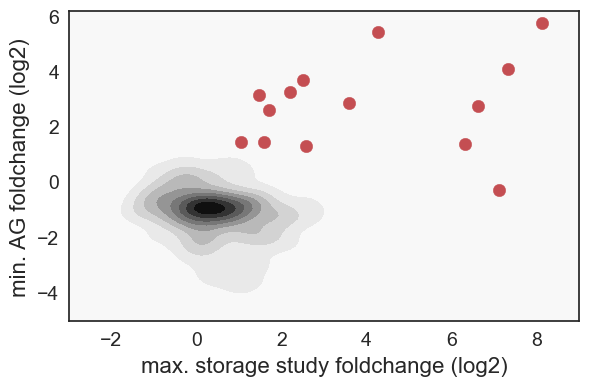

In [84]:
ax = plt.axes()
fig = ax.figure
sn.kdeplot(clean_extremes['storage'],
           clean_extremes['freeze_thaw'],
           shade=True,
           cmap='Greys',
           ax=ax)
ax.scatter(clean_extremes.loc[blooms, 'storage'],
           clean_extremes.loc[blooms, 'freeze_thaw'],
           s=80, color=sn.color_palette()[2])
ax.set_xlim([-3, 9])
ax.set_ylim([-5, 6.25])
ax.set_xlabel('max. storage study foldchange (log2)',fontsize=16)
ax.set_ylabel('min. AG foldchange (log2)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

plt.savefig('../results/fig1-blooming-identification-kde.pdf')

In [85]:
f = lambda x: x['freeze_thaw']*0.01 + x['storage']
extremes = extremes.fillna(0.0)
extremes['score'] = extremes.apply(f, axis=1)

In [63]:
extremes = pd.merge(extremes, res, 
                    left_index=True, right_index=True)
order_list = extremes.loc[blooms].sort_values('score', ascending=False)

In [64]:
bloom_seqs = []
bloom_taxa = []

for idx, extreme_seq in enumerate(order_list.index):
    bloom_seqs.append(
        '>%s\n%s' % (extreme_seq, freeze_thaw.loc[extreme_seq, 'sequence'])
        )
    bloom_taxa.append(
        '%s\t%s' % (extreme_seq, freeze_thaw.loc[extreme_seq, 'taxonomy'])
        )

    print('%0d %f %s' % (idx + 1, 
                         extremes.loc[extreme_seq, 'score'],
                         freeze_thaw.loc[extreme_seq, 'taxonomy'],
                         ))
    

1 281.330807 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__fragi
2 160.953053 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Trabulsiella;s__farmeri
3 138.788755 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae
4 97.452242 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Escherichia;s__coli
5 78.817365 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Morganella;s__
6 19.742467 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__
7 12.105456 k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Citrobacter;s__
8 6.018693 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__zeae
9 5.845

And now, we're going to write the sequences, and a subset of the sequences to files.

In [65]:
with open('../data/newbloom.all.fna', 'w') as f_:
    f_.write('\n\n'.join(bloom_seqs))

with open('../data/newbloom.10.fna', 'w') as f_:
    f_.write('\n\n'.join(bloom_seqs[:10]))
    
with open('../results/bloom_taxa.txt', 'w') as f_:
    f_.write('\n\n'.join(bloom_taxa))

# Taxa Plots

Finally, we're going to look at the change in taxonomy across the four cross sectional experiments before and after bloom filtering. We'll first filter out the bloom sequences to identify the post-bloom table. To do this, we'll first establish a list of high abundance classes, which we'll use in the collapse function.

In [87]:
sub_keep = ['c__Gammaproteobacteria',
            'c__Clostridia',
            'c__Bacilli',
            'c__Erysipelotrichi',
            'c__Bacteroidia',
            'c__Actinobacteria',
            'c__Mollicutes',
            'c__Other'
            ]

In [99]:
order_list.iloc[:10].index # [:10]

Index(['691656f33e727f8857f5c9ee40ed05b1', '41f1c6e4d1e4cc653df22555bfab5796',
       'ece1af985b63ebccd2833e9b5f0432e3', '04195686f2b70585790ec75320de0d6f',
       'df3f8cdac76c62baa98469c33b82d8df', 'bc23d2ee539bf2f52faf789289af7879',
       '4e1758e81adcb1107024ee52c0113a6f', '6ed7152332889b69d2d2f33c53b68934',
       'd56536a97c18adccf18eb08958d93345', 'c18afe570abfe82d2f746ecc6e291bab'],
      dtype='object')

Let's filter out the bloom sequences.

In [100]:
extreme_seqs = set(freeze_thaw.loc[order_list.index, 'sequence'].values)
fec_sotu_filter = fec_sotu_b.filter(freeze_thaw.loc[order_list.iloc[:10].index, 'sequence'], 
                                    invert=True, axis='observation', inplace=False)

Now, we're going to partition and sum the classes, to look at the taxonomic distribution before and after filtering, and use these to generate data frames.

In [101]:
def partition_biom(id_, md):
    tax = md['taxonomy']
    if len(tax) > 2 and tax[2] in sub_keep:
        return tax[2]
    else:
        return 'c__Other'

In [102]:
pre_ = pd.DataFrame(
    {id_: tab.sum(axis='sample') for id_, tab in 
     fec_sotu_b.norm().partition(partition_biom, axis='observation')},
    index=fec_sotu_b.ids('sample')
    )
post = pd.DataFrame(
    {id_: tab.sum(axis='sample') for id_, tab in 
     fec_sotu_filter.norm().partition(partition_biom, axis='observation')},
    index=fec_sotu_filter.ids('sample')
    )

Finally, we'll add study information and group by the study.

In [103]:
pre_['STUDY'] = fec_meta['STUDY']
post['STUDY'] = fec_meta['STUDY']

pre_class = pre_.groupby('STUDY').mean()[sub_keep]
postclass = post.groupby('STUDY').mean()[sub_keep]

# Plots the taxonomy plots

We'll write a quick function to help make the stacked bar chart. 

In [104]:
def make_taxa_boxplot(taxa, order, ax, colors=None):
    """Plots a barchart of the taxonomy   
    
    Parameters
    ----------
    taxa: DataFrame
        A pandas dataframe with the samples or studies in
        the index and the clades in the columns
    order : array-like
        The order in which columns should be plotted
    ax : Axes
        A matplotlib axis object where the data should be plotted
    colors : None, array-like, optional
        A valid matplotlib color representation at least as long
        as the taxa order.
        
    Returns
    -------
        A stacked taxonomy barchart will be plotted on the axis.
    """
    
    # Gets the color palete
    if colors is None:
        colors = sn.color_palette('Set1', len(order))

    taxa = taxa[order]
    low = np.cumsum(taxa, axis=1) - taxa
    
    # Plots the boxplot
    for class_, color in zip(*(sub_keep, colors)):
        ax.bar(left=np.arange(0, len(taxa.index)) + 0.1,
               bottom=low[class_],
               height=taxa[class_],
               width=0.8,
               color=color,
               )

    ax.set_xticks(np.arange(0, len(taxa.index)) + 0.5)
    ax.set_xticklabels([t.replace('_', ' ') for t in taxa.index])
    
    ax.set_ylim([0, 1])
    ax.set_ylabel('Relative Abundance')


We'll also define a colormap which will highlight the gamma proteobacteria in the samples. 

In [105]:
colors = sn.color_palette('Pastel1', 7)
colors[0] = sn.color_palette('Set1', 2)[0]
colors.append([0.85, 0.85, 0.85])

Finally, let's plot the pre and post filtering figures and save them.

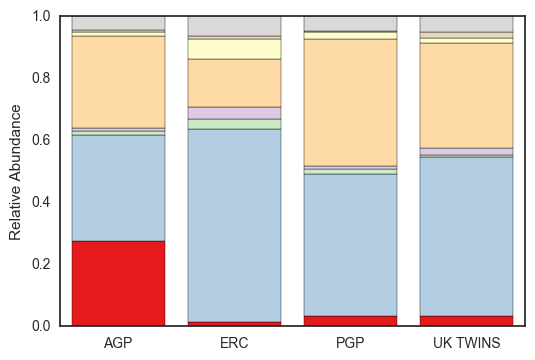

In [106]:
fig_tb, ax = plt.subplots(1, 1)
make_taxa_boxplot(pre_class, sub_keep, ax, colors)
fig.savefig('taxa_pre_filtering.pdf')

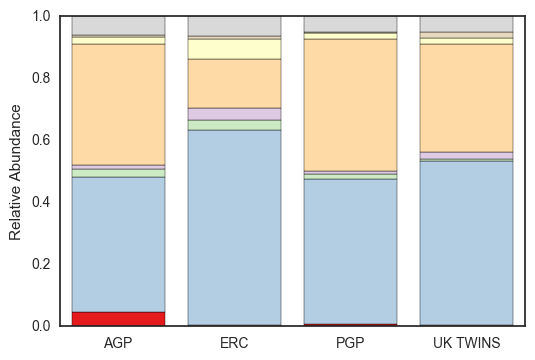

In [107]:
fig_ta, ax = plt.subplots(1, 1)
make_taxa_boxplot(postclass, sub_keep, ax, colors)
fig.savefig('../results/taxa_post_filtering.pdf')

Finally, we'll generate a legend.

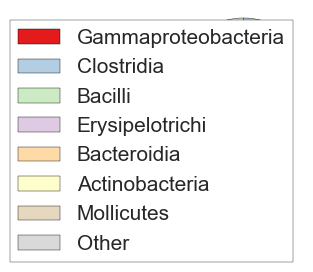

In [108]:
fig_lt, ax = plt.subplots(1, 1)
ax.set_position((0.4, 0.4, 0.2, 0.2))
pie_ = ax.pie([1 / len(sub_keep)] * len(sub_keep), colors=colors)
l = ax.legend(labels=[c.replace('c__', '') for c in sub_keep],
              frameon=True,
              fontsize=15)
plt.savefig('../results/taxa_legend.pdf')

In conclusion, we can take advantage of the microbes identified to be blooming in previous studies, combined with comparison between shipped and fresh frozen samples, to identify candidate taxa that bloom in storage conditions in the American Gut project.

An advantage of performing such analysis on a sub-OTU level (i.e. the output of the Deblur algorithm), is that we can identify and remove the exact blooming bacterial sequences, whereas using traditional OTU based methods would require removal of the blooming bacteria and all close sequences, which can lead to much higher numbers of bacteria removed.

Note that choosing the number of candidate blooming bacteria to remove is a type-1/type-2 balance. Removal of more bacteria will reduce the effect of shipment, at the cost of losing more bacteria for analysis.

While all bacteria may change during shipment, it seems only a small number of them exhibit a drastic growth. By removal of as little as the top 8 blooming bacteria, we can greatly reduce the effect of shipment. This leads to a great reduction in the noise within American Gut samples (since not all samples are undergo the same shipment conditions/duration), as well as enable comparison to other, fresh frozen studies.


# References
<ol><li><a id='1'></a>Song, S.J., Amir, A.; Metcalf, J.L.; Amato, K.R.; Xu, Z.Z.; Humphrey, G.; Knight, R. (2016). "<a href="http://msystems.asm.org/content/1/3/e00021-16">Preservation Methods Differ in Fecal Microbiome Stability, Affecting Suitability for Field Studies</a>. <em>mSystems</em>. 1: e00021-16
</li><li><a id="2"></a>Sinha, R.; Chen, J.; Amir, A,; Vogtmann, E.; Shi, J.; Inman, K.S.; Flores, R.; Sampson, J.; Knight, R.; Chia, N. (2016) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26604270">Collecting fecal samples for microbiome analyses in epidemiology studies.</a>" <em>Cancer Epidemiol Biomarkers Prev</em> 25: 407-416.
</li><li><a id="3"></a>Goodrich, J.K.; Waters, J.L.; Poole, A.C.; Sutter, J.L.; Blekhman, R.; Beaumont, M.; Van Treuren, W.; Knight, R.; Bell, J.T.; Spector, T.D.; Clark, A.G.; Ley, R.E. (2014). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25417156">Human genetics shape the gut microbiome</a>." <em>Cell</em>. 159: 789-799.
</li><li><a id="4"></a>Vitaglione, P.; Mennella, I.; Ferracane, R.; Rivellese, A.A.; Giacco, R.; Ercolini, D.; Gibbons, S.; La Storia, A.; Gilbert, J.A.; Jonnalagadda, S.; Thielecke, F.; Galo, M.A.; Scalfi, L.; Fogliano, V. (2015). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25646321">Whole-grain wheat consumption reduces inflammation in a randomized controlled trial on overweight and obese subjects with unhealthy dietary and lifestyle behaviors: role of polyphenols bound to cereal dietary fiber</a>." <em>Am J Clin Nutr</em> 101: 251-261.
</li><li><a id="5"></a>Mandal, S.; Van Treuren, W.; White, R.A.; Eggesbo, M.; Knight, R.; Peddada, S.D (2015) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26028277">Analysis of composition of microbiomes: a novel method for studying microbial composition</a>." <em>Microb Ecol Health Dis</em> 29:27663.
</li></ol>